# STAR Classification

This notebook contains code to classify job titles according to the Staff Titles and Roles (STAR) classification developed by del Junco and de Jong. See documentation for detailed explanation of the classification scheme and implementation.

## Load packages

In [3]:
import pandas as pd
import csv
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import re
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

## Load data and select what to classify

In [15]:
#load a table containing minimally the columns:
#job_title
#umetrics_occupational_class AS uoc
#systematic_occupational_class AS soc

#here we load a csv file but you can also use a pandas dataframe directly from a SQL query. 

In [4]:
job_titles_raw = pd.read_csv('../STAR-Classification-Dev/20220805_job_titles_SOC.csv')
# job_titles_raw.rename(columns={'systematic_occupational_class':'soc', 'umetrics_occupational_class':'uoc'}, inplace = True)

In [5]:
job_titles_raw.head(1)

,Unnamed: 0,uoc,job_title
0,1,Graduate Student,Research Assistant


In [38]:
# #replace this with whatever condition on soc or uoc you want to use to select Staff, e.g:
# staff_condition = job_titles_raw.soc == 'Staff'
#condition below picks all titles
staff_condition = (job_titles_raw.job_title == 'dummy') | True

In [39]:
#select distinct job titles that match this condition
job_titles = job_titles_raw[staff_condition][['job_title']].drop_duplicates()
# job_titles = job_titles_raw[['job_title']].drop_duplicates()

In [40]:
len(job_titles_raw)

6520

In [41]:
len(job_titles)

6374

==========================================================================================

#### Aside on UOC

The uoc has some spelling errors, so be sure to check and standardize it for your sample if you are using it to select staff titles to classify.

In [42]:
job_titles_raw.uoc.value_counts()

Research Facilitation     2762
Research                  1466
Technical Support          801
Clinical                   579
Other                      327
Instructional              166
Faculty                    143
Graduate Student           120
Undergraduate               90
Other Staff                 34
Post Graduate Research      32
Name: uoc, dtype: int64

In [43]:
replace_dict = {'Undergraduate ': 'Undergraduate', 'faculty':'Faculty', 'Graduate Student ':'Graduate Student', 'Research ':'Research', 'REsearch Facilitation':'Research Facilitation', 'Other staff':'Other Staff'}

for key, val in replace_dict.items():
    job_titles_raw.uoc.replace(to_replace=key, value=val, inplace=True)
    
job_titles_raw.uoc.value_counts()

Research Facilitation     2762
Research                  1466
Technical Support          801
Clinical                   579
Other                      327
Instructional              166
Faculty                    143
Graduate Student           120
Undergraduate               90
Other Staff                 34
Post Graduate Research      32
Name: uoc, dtype: int64

==========================================================================================

## Clean titles

In [44]:
PUNC_MARKS = ["-", "_", "/", ")", "(", ",", ".", '&', ";", "`", ':']#,'0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ROMAN_NUMS = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']

#read in the standard/alternative spellings that we've saved
def get_replacements():
    
    standard_terms = []
    alt_spellings = []
    
    #standardized-job-terms-rw.csv has the standardized spelling in the first column 
    #and alternative spellings in subsequent columns
    with open('standardized-job-terms-rw.csv') as f:
        reader = csv.reader(f)
        #skip header
        next(reader)
        for row in reader:
            standard_terms.append(row[0])
            temp = row[1:]
            while("" in temp) : 
                temp.remove("") 
            alt_spellings.append(temp)
       
    return standard_terms, alt_spellings 

#define uninformative terms (e.g. fiscal year denotes when the employee was paid, 
#                               not that they are a financial expert)
UNINF = ['fiscal year', 'fy']

#clean job titles
def clean_job_title(job_title, standard_terms, alt_spellings):
    
    #replace NaNs
    if not isinstance(job_title, str):
        return "na"
    
    #make lowercase
    jt = job_title.casefold()
    
    #removing punctuation
    for mark in PUNC_MARKS:
        jt = jt.replace(mark, " ")
        
    #removing roman numerals
    for rn in ROMAN_NUMS:
        jt = re.sub(r"\b%s\b" % rn , ' ', jt)
        
    #remove uninformative terms that might interfere with classification, 
    #e.g. 'fiscal year'
        
    for ut in UNINF:
        jt = re.sub(r"\b%s\b" % ut , ' ', jt)
        
    #standardize terms, 
    #e.g. 'mngr' becomes manager
        
    for i, st in enumerate(standard_terms):
        for alt_sp in alt_spellings[i]:
            jt = re.sub(r"\b%s\b" % alt_sp , st, jt)
            #jt = jt.replace(alt_sp, st)
    
    #remove extra whitespaces
    jt = " ".join(jt.split())
    
    
    return jt
            

Process the job titles

In [45]:
%%time
standard_terms, alt_spellings = get_replacements()
job_titles.loc[:, "job_title_clean"] = [clean_job_title(jt, standard_terms, alt_spellings) for jt in job_titles["job_title"]]

CPU times: user 1.86 s, sys: 4.61 ms, total: 1.87 s
Wall time: 1.87 s


## Classify titles

Using logical rules:

In [58]:
def classify(jt):
    
    #filter leadership
    or_terms = ['dean', 'chair', 'provost']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'leadership'
    
    #filter grant specialists
    or_terms = ['grant', 'proposal']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'grants'
    
    #filter safety and compliance specialists
    or_terms = ['compliance', 'quality', 'safety', 'evaluation', 'regulatory', 'insurance', 'policy', 'monitor']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'accountability'
    
    #filter communications specialists
    or_terms = ['writer', 'editor', 'communication', 'outreach', 'media', 'marketing', 'webmaster', 'education', 'graphic', 'designer']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'communications'
    
    #filter librarians
    or_terms = ['librarian', 'archivist']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'librarian'
    
    #filter accountants
    or_terms = ['accountant', 'accounting', 'fiscal', 'financial']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'financial'
    
    #filter clinical research coordinators
    or_terms = ['clinical trial', 'clinical research']
    and_terms = ['manager', 'coordinator', 'specialist']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]) and any([re.search(r"\b%s\b" % term, jt) for term in and_terms]):
        return "clinical research coordinator"
    
    #filter doctors
    or_terms = ['physician', 'resident']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'physician'
    
    #filter other medical professionals
    or_terms = ['social worker', 'nurse', 'dietician', 'medical assistant', 'health professional', 'phlebotomist', 'therapist', 'psychologist', 'pharmacist']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'non-md health professional'
    
    #filter human research subject technicians
    or_terms = ['interviewer', 'human', 'patient', 'clinical subject', 'recruitment', 'survey']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'human technician'
    
    #filter animal research subject technicians
    or_terms = ['animal', 'vet', 'wildlife']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'animal technician'
    
    #filter IT and lab technicians
    or_terms = ['engineer', 'data', 'it', 'informatics', 'information', 'statistics', 'computer', 'mechanic', 'machinist', 'application', 'programmer']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'lab & IT technician'
    
    or_terms = ['develop', 'specialist', 'analyst', 'architect', 'consultant','administrator', 'technician', 'specialist']
    and_terms = ['software', 'web', 'system', 'survey', 'laboratory']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]) and any([re.search(r"\b%s\b" % term, jt) for term in and_terms]):
        return 'lab & IT technician'
    
    #filter general technicians
    or_terms = ['technician']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'technician'
    
    #filter instructors
    or_terms = ['instructor', 'lecturer', 'teacher', 'tutor', 'ta', 'educator']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'instructor'
        
    #filter admin assistants
    or_terms = ['administrator', 'office', 'program', 'clerical', 'project']
    and_terms = ['assistant', 'aide', 'support']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]) and any([re.search(r"\b%s\b" % term, jt) for term in and_terms]):
        return 'administrative assistant'
    
    #filter admin assistants
    or_terms = ['secretary', 'receptionist', 'clerical']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'administrative assistant'
        
    #filter administrators - we filter them late to classify e.g. website administrators as technicians
    or_terms = ['administrator', 'coordinator', 'develop', 'office', 'manager', 'supervisor', 'director']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'administrator'
    
    #filter administrators - we filter them late to classify e.g. website administrators as technicians
    or_terms = ['project', 'research']
    and_terms = ['support']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]) and any([re.search(r"\b%s\b" % term, jt) for term in and_terms]):
        return 'administrator'
    
    #filter RAs
    or_terms = ['research', 'laboratory', 'sci']
    and_terms = ['assistant', 'intern', 'aide']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]) and any([re.search(r"\b%s\b" % term, jt) for term in and_terms]):
        return 'research assistant'
    
    #filter faculty
    or_terms = ['professor', 'emeritus', 'principal investigator', 'veterinarian']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'faculty'
    
    #filter researchers
    or_terms = ['scholar', 'fellow', 'postdoc']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'researcher'
    
    or_terms = ['research', 'sci']
    not_terms = ['support']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]) and not any([re.search(r"\b%s\b" % term, jt) for term in not_terms]):
        return 'researcher'
    
    #filter researchers
    or_terms = ['research']
    and_terms = ['associate', 'staff', 'academic']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]) and any([re.search(r"\b%s\b" % term, jt) for term in and_terms]):
        return 'researcher'
    
    #finally, anyone casually employed who has not already been classified as another category...
    or_terms = ['temporary', 'casual', 'hourly']
    if any([re.search(r"\b%s\b" % term, jt) for term in or_terms]):
        return 'temp'
    
    if jt == '' or jt == 'na':
        return 'insufficient information'
    
    return 'none'


Using dictionary of partial/complete job titles:

In [59]:
def classify_2(jt, contains_dict, matches_dict):
            
    for sc, strings in contains_dict.items():
        if any(re.search(r"\b%s\b" % string, jt) for string in strings):
            return sc
    
    for sc, titles in matches_dict.items():
        if jt in titles:
            return sc
            
    return False

Process data:

In [60]:
%%time
with open('title_contains_dict.txt', 'rb') as f:
    contains_dict = pickle.load(f)
with open('title_matches_dict.txt', 'rb') as f:
    matches_dict = pickle.load(f)
job_titles.loc[:, "star_class"] = [classify_2(jt, contains_dict, matches_dict) if classify_2(jt, contains_dict, matches_dict) else classify(jt) for jt in job_titles["job_title_clean"]]

CPU times: user 625 ms, sys: 3.06 ms, total: 628 ms
Wall time: 627 ms


## Merge with remaining data

In [61]:
jt_classified = job_titles_raw.merge(job_titles, how = 'left')
jt_classified['star_class'] = [sc.casefold() for sc in jt_classified.star_class]
#jt_classified['star_class'] = [sc.casefold() if soc == 'Staff' else soc.casefold() for (sc, soc) in zip(jt_classified.star_class, jt_classified.soc)]

In [62]:
print(jt_classified.star_class.nunique())
display(jt_classified.star_class.value_counts())

24


administrator                    1383
lab & it technician              1375
researcher                        617
non-md health professional        436
technician                        390
research assistant                318
communications                    297
administrative assistant          238
human technician                  182
insufficient information          173
instructor                        162
accountability                    150
financial                         142
animal technician                 127
clinical research coordinator      98
grants                             81
temp                               79
other specialist                   62
librarian                          47
other                              47
leadership                         45
physician                          40
faculty                            29
undergraduate                       2
Name: star_class, dtype: int64

## Super classes

In [63]:
#====modify this code to assign your own super-classes====

#group classes into super-classes
academic_classes = ['other student', 'undergraduate' , 'graduate student', 'post graduate research', 'faculty']
no_info_classes = ['temp', 'insufficient information']
other_classes = ['other']
instructor_classes = ['instructor']
tech_classes = ['technician', 'human technician', 'animal technician', 'lab & it technician']
research_classes = ['researcher', 'research assistant']
specialist_classes = ['clinical research coordinator', 'communications', 'accountability', 'financial', 'grants', 'librarian', 'other specialist']
admin_classes = ['leadership', 'administrator', 'administrative assistant']
med_classes = ['physician', 'non-md health professional']
#uncomment the following line if you have unclassified titles (check this below)
#unclassified = ['none']

#define the names of the super classes
SUPER_CLASSES_DICT = {'medical professionals':med_classes, 'academic track':academic_classes, 
                     'instructors':instructor_classes, 'researchers':research_classes, 
                     'technicians':tech_classes,  'specialists':specialist_classes, 
                     'administrators':admin_classes, 'other':other_classes, 
                     'insufficient information':no_info_classes}#, 
                      #uncomment the following line if you expect to have unclassified titles 
                      #'unclassified':unclassified}

In [64]:
def assign_super_class(sc):
    
    for key, val in SUPER_CLASSES_DICT.items():
        if sc in val:
            return key

In [65]:
jt_classified['super_class'] = [assign_super_class(sc) for sc in jt_classified.star_class]

Check that every class has a super-class:

In [66]:
if sum([1 for sc in SUPER_CLASSES_DICT.values() for c in sc]) == jt_classified['star_class'].nunique():
    print('all classes are in a super class')
else:
    for c in jt_classified['star_class'].unique():
        if c not in [c for sc in SUPER_CLASSES_DICT.values() for c in sc]:
            print(c)

In [67]:
jt_classified.head(1)

,Unnamed: 0,uoc,job_title,job_title_clean,star_class,super_class
0,1,Graduate Student,Research Assistant,research assistant,research assistant,researchers


## Descriptive statistics

#### Fraction of classified titles

In [68]:
print('fraction of unique cleaned titles remaining unclassified: ')
print(jt_classified[(staff_condition) & (jt_classified.star_class == 'none')]['job_title_clean'].nunique()/jt_classified.job_title_clean.nunique())
print('number of unique cleaned titles remaining unclassified: ')
print(jt_classified[(staff_condition) & (jt_classified.star_class == 'none')]['job_title_clean'].nunique())
print('fraction of records remaining unclassified: ')
print(len(jt_classified[(staff_condition) & (jt_classified.star_class == 'none')])/len(jt_classified))
print('number of records remaining unclassified: ')
print(len(jt_classified[(staff_condition) & (jt_classified.star_class == 'none')]))

fraction of unique cleaned titles remaining unclassified: 
0.0
number of unique cleaned titles remaining unclassified: 
0
fraction of records remaining unclassified: 
0.0
number of records remaining unclassified: 
0


#### Validation
Generate a validation sample of size N for manual validation. To validate, add a column called 'val' and fill it with a 1 if the title is correct, 0 if incorrect, or 2 if unsure.

In [40]:
#generate and export sample
N = 1000
val_sample = jt_classified[['job_title', 'job_title_clean']].sample(N)
val_sample.to_csv('validation_sample.csv')

In [41]:
validated = pd.read_csv('validation_sample.csv')

In [42]:
# #generating random validation tags to test plotting code -- don't do this for actual validation!
# import random
# validated['val'] = [random.choice([0, 1, 2]) for i in range(N)]

Text(0.5, 1.0, 'validation per record')

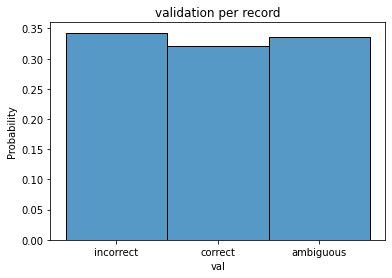

In [43]:
sns.histplot(data = validated, x = 'val', stat='probability', discrete = True)
plt.xticks(ticks = [0, 1, 2], labels = ['incorrect', 'correct', 'ambiguous'])
plt.title('validation per record')

Text(0.5, 1.0, 'validation per unique cleaned title')

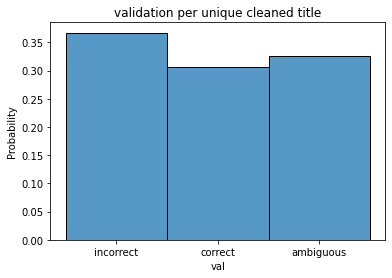

In [44]:
sns.histplot(data = validated[['job_title_clean', 'val']].drop_duplicates(), x = 'val', stat='probability', discrete = True)
plt.xticks(ticks = [0, 1, 2], labels = ['incorrect', 'correct', 'ambiguous'])
plt.title('validation per unique cleaned title')

#### Distribution of classes

In [69]:
def make_pie_chart(df, labels = False):
    
    super_classes = [val for val in SUPER_CLASSES_DICT.values()]
    super_tags = [key for key in SUPER_CLASSES_DICT.keys()]    
    sub_tags = [c for super_class in super_classes for c in super_class]
    
    value_dict = dict(df['star_class'].value_counts())
    val_list = []
    for super_class in super_classes:
        val_list.append([value_dict.get(key) for key in super_class])
        
    fig, ax = plt.subplots(figsize = (20, 20))

    size = 0.4
    vals = val_list
    flat_vals = [item for subl in val_list for item in subl]

    cmap = sns.color_palette("tab10") #qualitative cmap with 5 color categories
    outer_colors = sns.color_palette("tab10", len(super_classes))

    def adjust_lightness(color, amount=0.5):
        import matplotlib.colors as mc
        import colorsys
        try:
            c = mc.cnames[color]
        except:
            c = color
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

    inner_colors = [[adjust_lightness(color, amount) for amount in np.linspace(0.7, 1.3, len(super_class))] if len(super_class) > 1 else [color] for (color, super_class) in zip(outer_colors, super_classes)]
    flat_colors = [item for subl in inner_colors for item in subl]
    
    if labels:

        ax.pie([sum(vals) for vals in val_list], radius=1-size, colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w'), labels = super_tags, labeldistance = 0.5, rotatelabels = True)

        ax.pie(flat_vals, radius=1, colors=flat_colors,
           wedgeprops=dict(width=size, edgecolor='w'), labels = sub_tags, labeldistance = 0.7, rotatelabels = True)

    else:

        ax.pie([sum(vals) for vals in val_list], radius=1-size, colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w'))

        ax.pie(flat_vals, radius=1, colors=flat_colors,
           wedgeprops=dict(width=size, edgecolor='w'))
        
    fig.set_tight_layout(True)